In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/career-con-2019/sample_submission.csv
/kaggle/input/career-con-2019/X_test.csv
/kaggle/input/career-con-2019/y_train.csv
/kaggle/input/career-con-2019/X_train.csv


# Will need to merge input & output csv files

# Import pytorch , pytorch lightning etc... 

# All bulk imports below

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint , EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# below import is already deprecated so use torch metrics
# from pytorch_lightning.metrics.functional import accuracy
from torchmetrics import Accuracy
from sklearn.metrics import classification_report , confusion_matrix



# Set up matplotlib

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00','#FF7D00','#FF006D','#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=16,10

In [4]:
pl.seed_everything(42) # make everything reproducible

42

In [5]:
X_train = pd.read_csv('/kaggle/input/career-con-2019/X_train.csv')
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [6]:
y_train = pd.read_csv('/kaggle/input/career-con-2019/y_train.csv')
y_train.head() # features that are labels

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


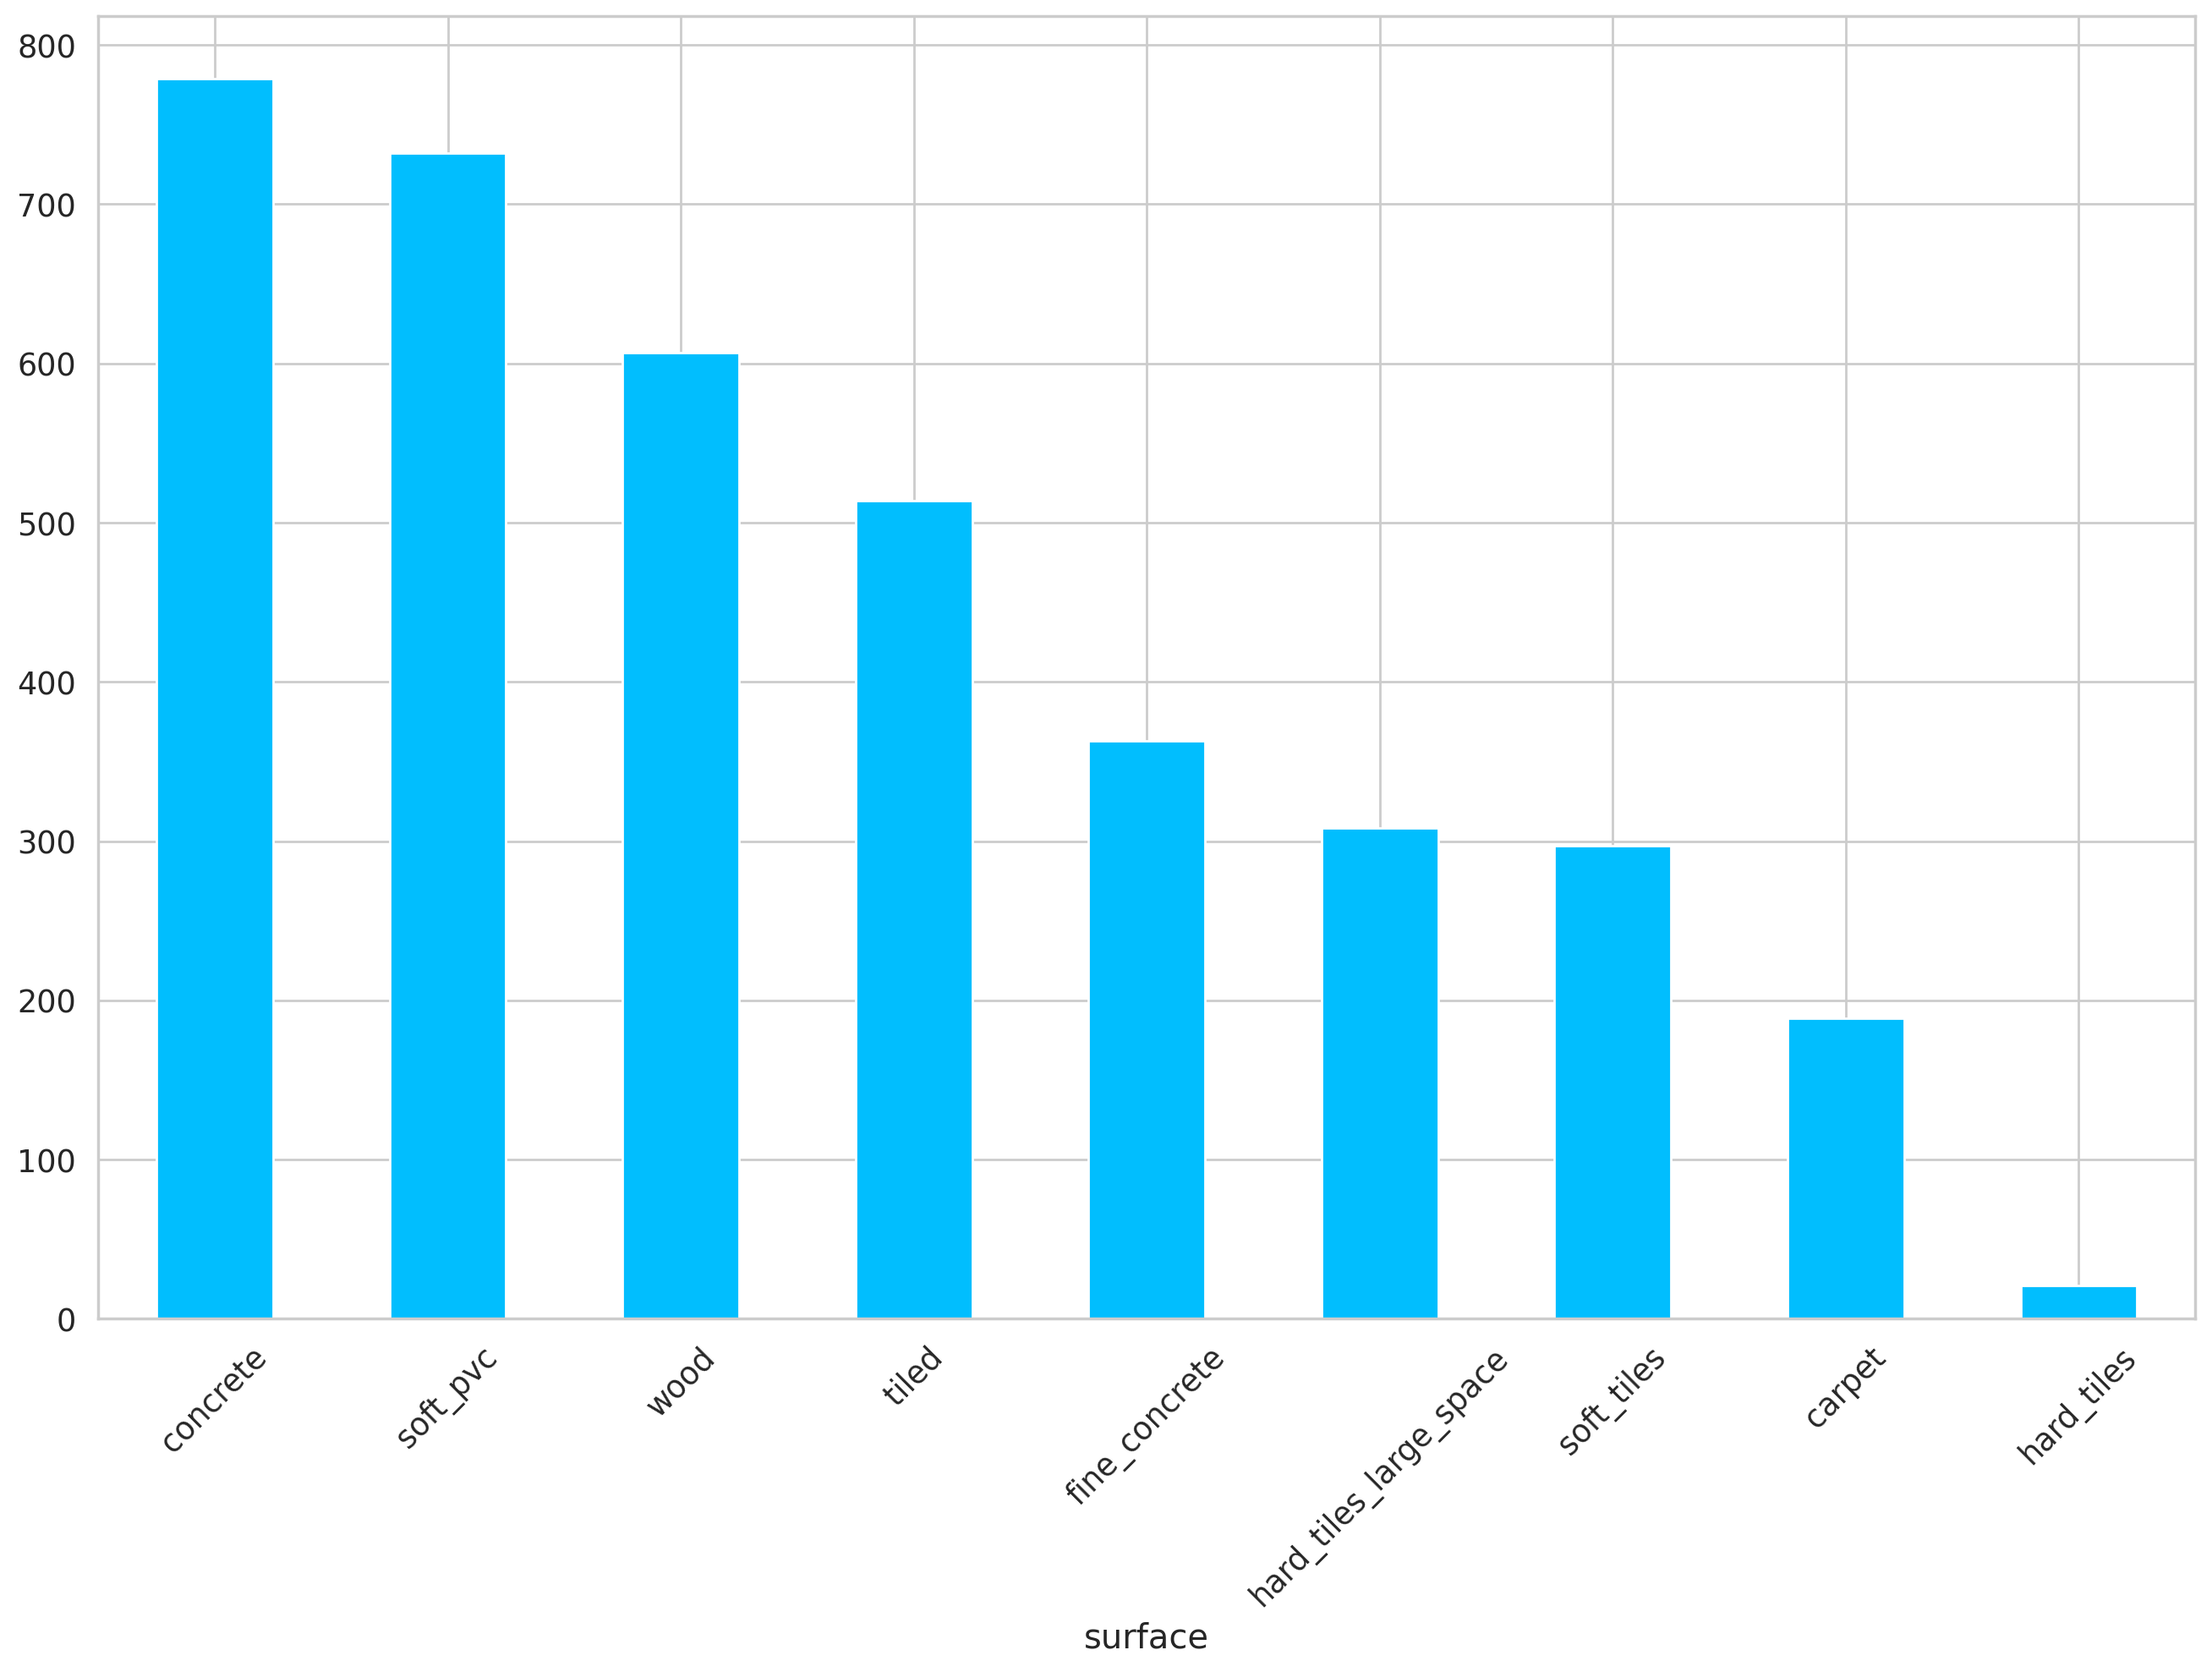

In [7]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

# Distribution is not balanced, so might use resampling or other technique for balancing this data set

# Preprocessing to convert string values of surfaces to integers for neural network

In [8]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [9]:
encoded_labels[:5]

array([2, 1, 1, 1, 6])

In [10]:
#labels are stored in the classes_ property in label encoder
label_encoder.classes_
# to reverse transformation if and when needed

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [11]:
y_train["label"]=encoded_labels

In [12]:
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [13]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [14]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [15]:
X_train.series_id.value_counts()

series_id
3809    128
0       128
3770    128
3771    128
3772    128
       ... 
5       128
6       128
7       128
8       128
9       128
Name: count, Length: 3810, dtype: int64

In [16]:
(X_train.series_id.value_counts()==128).sum() == len(y_train)
# check that all the sequences have 128 of series ids (grouped datapoints for each time step)

True

In [17]:
# group by series_id

sequences = []

for series_id , group in X_train.groupby("series_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.series_id== series_id].iloc[0].label

    sequences.append((sequence_features,label ))
    

In [18]:
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

In [19]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)

len(train_sequences) , len(test_sequences)



(3048, 762)

# Dataset

In [20]:
class SurfaceDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self,idx):
        sequence , label = self.sequences[idx]
        return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).long()
        )

In [21]:
class SurfaceDataModule(pl.LightningDataModule):
    
    def __init__(self, train_sequences , test_sequences , batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)
        

    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=cpu_count())
    
    def val_dataloader(self):
        return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size,
        shuffle=False,
        num_workers=cpu_count())
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    

In [22]:
N_EPOCHS = 250
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

# Model

In [23]:
class SequenceModel(nn.Module):
    # classification, number of hidden units, number of layers for LSTM
    
    def __init__(self, n_features, n_classes , n_hidden=256, n_layers=3):
        super().__init__()
        
        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size=n_hidden,
        num_layers=n_layers,
        batch_first=True,
        dropout=0.75)
        
        self.classifier = nn.Linear(n_hidden , n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        
        return self.classifier(out)

In [24]:
# !kill 4839
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/

# from pytorch_lightning.callbacks import Callback

# class MetricsLogger(Callback):
#     def on_epoch_end(self, trainer, pl_module):
#         print(f"Epoch {trainer.current_epoch}: train_loss={trainer.callback_metrics['train_loss']}")

In [25]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

# ORIGINAL VERSION - NOT USING THIS AS CANNOT SEE ALL METRICS FOR ALL EPOCHS

In [26]:
# class SurfacePredictor(pl.LightningModule):
    
#     def __init__(self, n_features:int , n_classes: int):
#         super().__init__()
#         self.model = SequenceModel(n_features,n_classes)
#         self.criterion = nn.CrossEntropyLoss()
#         self.accuracy_metric = Accuracy(task='multiclass', num_classes=n_classes) # updated syntax for new version of pytorch lightning torchmetrics Accuracy 
        
#     def forward(self,  x, labels=None):
#         output = self.model(x)
#         loss=0
#         if labels is not None:
#             loss=self.criterion(output, labels)
#         return loss, output
    
#     def training_step(self, batch, batch_idx):
#         sequences = batch["sequence"]
#         labels = batch["label"]
#         loss, outputs = self(sequences , labels)
#         predictions = torch.argmax(outputs , dim=1)
#         step_accuracy=self.accuracy_metric(predictions, labels)
        
#         self.log("train_loss", loss , prog_bar=True , logger=True )
#         self.log("train_accuracy" , step_accuracy, prog_bar=True , logger=True)
#         return {"loss":loss , "accuracy":step_accuracy}
#     # log everything to tensorboard
    
#     def validation_step(self, batch, batch_idx):
#         sequences = batch["sequence"]
#         labels = batch["label"]
#         loss, outputs = self(sequences , labels)
#         predictions = torch.argmax(outputs , dim=1)
#         step_accuracy=self.accuracy_metric(predictions, labels)
        
#         self.log("val_loss", loss , prog_bar=True , logger=True )
#         self.log("val_accuracy" , step_accuracy, prog_bar=True , logger=True)
#         return {"loss":loss , "accuracy":step_accuracy}
        
#     def test_step(self, batch, batch_idx):
#         sequences = batch["sequence"]
#         labels = batch["label"]
#         loss, outputs = self(sequences , labels)
#         predictions = torch.argmax(outputs , dim=1)
#         step_accuracy=self.accuracy_metric(predictions, labels)
        
#         self.log("test_loss", loss , prog_bar=True , logger=True )
#         self.log("test_accuracy" , step_accuracy, prog_bar=True, logger=True)
#         return {"loss":loss , "accuracy":step_accuracy}        
        
    
#     def configure_optimizers(self):
#         return optim.Adam(self.parameters(), lr=0.0001)

# #     def on_train_epoch_end(self, outputs):
# #         # Calculate and log epoch metrics to .txt file
# #         avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
# #         avg_train_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()
# #         self.log_to_file("train", avg_train_loss, avg_train_accuracy, self.current_epoch)
    
# #     def on_validation_epoch_end(self, outputs):
# #         # Calculate and log epoch metrics to .txt file
# #         avg_val_loss = torch.stack([x["loss"] for x in outputs]).mean()
# #         avg_val_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()
# #         self.log_to_file("val", avg_val_loss, avg_val_accuracy, self.current_epoch)
    
# #     def log_to_file(self, stage, loss, accuracy, epoch):
# #         with open("training_logs.txt", "a") as f:
# #             f.write(f"Epoch {epoch + 1}, {stage}_loss: {loss:.4f}, {stage}_accuracy: {accuracy:.4f}\n")

# NEW VERSION TO VISUALISE TRAINING PERFORMANCE METRICS AND PRINT METRICS FOR ALL EPOCHS

In [27]:
# import matplotlib.pyplot as plt

# class SurfacePredictor(pl.LightningModule):
    
#     def __init__(self, n_features:int , n_classes: int):
#         super().__init__()
#         self.model = SequenceModel(n_features, n_classes)
#         self.criterion = nn.CrossEntropyLoss()
#         self.accuracy_metric = Accuracy(task='multiclass', num_classes=n_classes)  # Accuracy metric
#         self.train_losses = []  # To store training losses
#         self.train_accuracies = []  # To store training accuracies
#         self.val_losses = []  # To store validation losses
#         self.val_accuracies = []  # To store validation accuracies
#         self.test_losses = []  # To store test losses
#         self.test_accuracies = []  # To store test accuracies
        
#     def forward(self, x, labels=None):
#         output = self.model(x)
#         loss = 0
#         if labels is not None:
#             loss = self.criterion(output, labels)
#         return loss, output
    
#     def training_step(self, batch, batch_idx):
#         sequences = batch["sequence"]
#         labels = batch["label"]
#         loss, outputs = self(sequences, labels)
#         predictions = torch.argmax(outputs, dim=1)
#         step_accuracy = self.accuracy_metric(predictions, labels)
        
#         self.log("train_loss", loss, prog_bar=True, logger=True)
#         self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        
#         # Store the metrics
#         self.train_losses.append(loss.item())
#         self.train_accuracies.append(step_accuracy.item())
        
#         return {"loss": loss, "accuracy": step_accuracy}
    
#     def validation_step(self, batch, batch_idx):
#         sequences = batch["sequence"]
#         labels = batch["label"]
#         loss, outputs = self(sequences, labels)
#         predictions = torch.argmax(outputs, dim=1)
#         step_accuracy = self.accuracy_metric(predictions, labels)
        
#         self.log("val_loss", loss, prog_bar=True, logger=True)
#         self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        
#         # Store the metrics
#         self.val_losses.append(loss.item())
#         self.val_accuracies.append(step_accuracy.item())
        
#         return {"loss": loss, "accuracy": step_accuracy}
    
#     def test_step(self, batch, batch_idx):
#         sequences = batch["sequence"]
#         labels = batch["label"]
#         loss, outputs = self(sequences, labels)
#         predictions = torch.argmax(outputs, dim=1)
#         step_accuracy = self.accuracy_metric(predictions, labels)
        
#         self.log("test_loss", loss, prog_bar=True, logger=True)
#         self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        
#         # Store the metrics for test data
#         self.test_losses.append(loss.item())
#         self.test_accuracies.append(step_accuracy.item())
        
#         return {"loss": loss, "accuracy": step_accuracy}
    
#     def on_epoch_end(self):
#         # Optional: log anything custom at the end of an epoch
#         pass
    
#     def on_train_end(self):
#         # Plot training and validation metrics at the end of training
#         epochs = range(1, len(self.train_losses) + 1)
        
#         # Plot Loss
#         plt.figure(figsize=(15, 5))
        
#         # Training and Validation Loss
#         plt.subplot(1, 3, 1)
#         plt.plot(epochs, self.train_losses, label="Train Loss")
#         plt.plot(epochs, self.val_losses, label="Val Loss")
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()

#         # Training and Validation Accuracy
#         plt.subplot(1, 3, 2)
#         plt.plot(epochs, self.train_accuracies, label="Train Accuracy")
#         plt.plot(epochs, self.val_accuracies, label="Val Accuracy")
#         plt.xlabel('Epochs')
#         plt.ylabel('Accuracy')
#         plt.legend()

#         # Save or show the plot
#         plt.tight_layout()
#         plt.show()
    
#     def plot_test_metrics(self):
#         # Plot test metrics after testing is done
#         epochs = range(1, len(self.test_losses) + 1)
        
#         # Plot Loss
#         plt.figure(figsize=(12, 5))

#         # Test Loss and Accuracy
#         plt.subplot(1, 2, 1)
#         plt.plot(epochs, self.test_losses, label="Test Loss")
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()

#         # Test Accuracy
#         plt.subplot(1, 2, 2)
#         plt.plot(epochs, self.test_accuracies, label="Test Accuracy")
#         plt.xlabel('Epochs')
#         plt.ylabel('Accuracy')
#         plt.legend()

#         # Save or show the plot
#         plt.tight_layout()
#         plt.show()
    
#     def configure_optimizers(self):
#         return optim.Adam(self.parameters(), lr=0.0001)


# NEW VERSION 2

In [28]:
# import matplotlib.pyplot as plt

# class SurfacePredictor(pl.LightningModule):
#     def __init__(self, n_features: int, n_classes: int):
#         super().__init__()
#         self.model = SequenceModel(n_features, n_classes)
#         self.criterion = nn.CrossEntropyLoss()
#         self.accuracy_metric = Accuracy(task='multiclass', num_classes=n_classes)
        
#         # Initialize lists to store outputs for each step in an epoch
#         self.train_losses = []
#         self.train_accuracies = []
#         self.val_losses = []
#         self.val_accuracies = []
        
#         # Initialize lists to store metrics for each epoch
#         self.epoch_train_losses = []
#         self.epoch_val_losses = []
#         self.epoch_train_accuracies = []
#         self.epoch_val_accuracies = []

#     def forward(self, x, labels=None):
#         output = self.model(x)
#         loss = 0
#         if labels is not None:
#             loss = self.criterion(output, labels)
#         return loss, output
    
#     def training_step(self, batch, batch_idx):
#         sequences = batch["sequence"]
#         labels = batch["label"]
#         loss, outputs = self(sequences, labels)
#         predictions = torch.argmax(outputs, dim=1)
#         step_accuracy = self.accuracy_metric(predictions, labels)
        
#         # Log for progress bar and TensorBoard
#         self.log("train_loss", loss, prog_bar=True, logger=True)
#         self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        
#         # Store outputs in lists for epoch end
#         self.train_losses.append(loss)
#         self.train_accuracies.append(step_accuracy)
        
#     def validation_step(self, batch, batch_idx):
#         sequences = batch["sequence"]
#         labels = batch["label"]
#         loss, outputs = self(sequences, labels)
#         predictions = torch.argmax(outputs, dim=1)
#         step_accuracy = self.accuracy_metric(predictions, labels)
        
#         # Log for progress bar and TensorBoard
#         self.log("val_loss", loss, prog_bar=True, logger=True)
#         self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        
#         # Store outputs in lists for epoch end
#         self.val_losses.append(loss)
#         self.val_accuracies.append(step_accuracy)
    
#     def on_train_epoch_end(self):
#         avg_train_loss = torch.stack(self.train_losses).mean()
#         avg_train_accuracy = torch.stack(self.train_accuracies).mean()
        
#         # Append to epoch lists
#         self.epoch_train_losses.append(avg_train_loss.item())
#         self.epoch_train_accuracies.append(avg_train_accuracy.item())
        
#         # Print the epoch metrics
#         print(f"Epoch {self.current_epoch + 1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")
        
#         # Clear lists for next epoch
#         self.train_losses.clear()
#         self.train_accuracies.clear()

#     def on_validation_epoch_end(self):
#         avg_val_loss = torch.stack(self.val_losses).mean()
#         avg_val_accuracy = torch.stack(self.val_accuracies).mean()
        
#         # Append to epoch lists
#         self.epoch_val_losses.append(avg_val_loss.item())
#         self.epoch_val_accuracies.append(avg_val_accuracy.item())
        
#         # Print the epoch metrics
#         print(f"Epoch {self.current_epoch + 1} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")
        
#         # Clear lists for next epoch
#         self.val_losses.clear()
#         self.val_accuracies.clear()
        
#     def configure_optimizers(self):
#         return optim.Adam(self.parameters(), lr=0.0001)
    
#     def plot_metrics(self):
#         # Plotting loss and accuracy
#         epochs = range(1, len(self.epoch_train_losses) + 1)
        
#         plt.figure(figsize=(12, 5))
        
#         # Plot Loss
#         plt.subplot(1, 2, 1)
#         plt.plot(epochs, self.epoch_train_losses, 'b', label='Training Loss')
#         plt.plot(epochs, self.epoch_val_losses, 'r', label='Validation Loss')
#         plt.title('Training and Validation Loss')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()
        
#         # Plot Accuracy
#         plt.subplot(1, 2, 2)
#         plt.plot(epochs, self.epoch_train_accuracies, 'b', label='Training Accuracy')
#         plt.plot(epochs, self.epoch_val_accuracies, 'r', label='Validation Accuracy')
#         plt.title('Training and Validation Accuracy')
#         plt.xlabel('Epochs')
#         plt.ylabel('Accuracy')
#         plt.legend()
        
#         plt.tight_layout()
#         plt.show()


# NEW VERSION 3

In [29]:
import matplotlib.pyplot as plt

class SurfacePredictor(pl.LightningModule):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=n_classes)
        
        # Initialize lists to store outputs for each step in an epoch
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        
        # Initialize lists to store metrics for each epoch
        self.epoch_train_losses = []
        self.epoch_val_losses = []
        self.epoch_train_accuracies = []
        self.epoch_val_accuracies = []

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = self.accuracy_metric(predictions, labels)
        
        # Log for progress bar and TensorBoard
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        # Store outputs in lists for epoch end
        self.train_losses.append(loss)
        self.train_accuracies.append(step_accuracy)
        
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = self.accuracy_metric(predictions, labels)
        
        # Log for progress bar and TensorBoard
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        # Store outputs in lists for epoch end
        self.val_losses.append(loss)
        self.val_accuracies.append(step_accuracy)
    
    def on_train_epoch_end(self):
        avg_train_loss = torch.stack(self.train_losses).mean()
        avg_train_accuracy = torch.stack(self.train_accuracies).mean()
        
        # Append to epoch lists
        self.epoch_train_losses.append(avg_train_loss.item())
        self.epoch_train_accuracies.append(avg_train_accuracy.item())
        
        # Print the epoch metrics
        print(f"Epoch {self.current_epoch + 1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")
        
        # Clear lists for next epoch
        self.train_losses.clear()
        self.train_accuracies.clear()

    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.val_losses).mean()
        avg_val_accuracy = torch.stack(self.val_accuracies).mean()
        
        # Append to epoch lists
        self.epoch_val_losses.append(avg_val_loss.item())
        self.epoch_val_accuracies.append(avg_val_accuracy.item())
        
        # Print the epoch metrics
        print(f"Epoch {self.current_epoch + 1} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")
        
        # Clear lists for next epoch
        self.val_losses.clear()
        self.val_accuracies.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)
    
    def plot_metrics(self):
        # Ensure both training and validation metrics have the same length
        num_epochs = min(len(self.epoch_train_losses), len(self.epoch_val_losses))
        epochs = range(1, num_epochs + 1)
        
        # Adjust the lists to the same length for consistent plotting
        train_losses = self.epoch_train_losses[:num_epochs]
        val_losses = self.epoch_val_losses[:num_epochs]
        train_accuracies = self.epoch_train_accuracies[:num_epochs]
        val_accuracies = self.epoch_val_accuracies[:num_epochs]
        
        plt.figure(figsize=(12, 5))
        
        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, 'b', label='Training Loss')
        plt.plot(epochs, val_losses, 'r', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
        plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()


In [30]:
model = SurfacePredictor(
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)

In [31]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [32]:
checkpoint_callback = ModelCheckpoint(
dirpath="checkpoints",
filename="best-checkpoint",
save_top_k=1,
verbose=True,
monitor="val_loss",
mode="min")

logger = TensorBoardLogger("lightning_logs", name="surface")

trainer=pl.Trainer(
logger=logger,
callbacks=[checkpoint_callback],
max_epochs=N_EPOCHS,
accelerator="gpu",  # Specify the accelerator type
devices=1,  # Number of GPUs to use
enable_progress_bar=True,  # Optionally set to False if you want to disable it
log_every_n_steps=1  # Adjust to match or be less than your batch count
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 - Validation Loss: 2.1960, Validation Accuracy: 0.1094


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 1 - Training Loss: 2.1936, Training Accuracy: 0.1378


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 2 - Training Loss: 2.1937, Training Accuracy: 0.1344


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 3 - Training Loss: 2.1936, Training Accuracy: 0.1284


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 4 - Training Loss: 2.1938, Training Accuracy: 0.1247


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 5 - Training Loss: 2.1943, Training Accuracy: 0.1267


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 6 - Training Loss: 2.1942, Training Accuracy: 0.1334


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 7 - Training Loss: 2.1945, Training Accuracy: 0.1175


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 8 - Training Loss: 2.1939, Training Accuracy: 0.1348


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 9 - Training Loss: 2.1938, Training Accuracy: 0.1415


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 10 - Training Loss: 2.1945, Training Accuracy: 0.1225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 11 - Training Loss: 2.1942, Training Accuracy: 0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 12 - Training Loss: 2.1940, Training Accuracy: 0.1339


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 13 - Training Loss: 2.1939, Training Accuracy: 0.1396


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 14 - Training Loss: 2.1940, Training Accuracy: 0.1215


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 15 - Training Loss: 2.1941, Training Accuracy: 0.1306


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 16 - Training Loss: 2.1939, Training Accuracy: 0.1292


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 17 - Training Loss: 2.1939, Training Accuracy: 0.1360


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 18 - Training Loss: 2.1937, Training Accuracy: 0.1283


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 19 - Training Loss: 2.1938, Training Accuracy: 0.1328


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 20 - Training Loss: 2.1936, Training Accuracy: 0.1300


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 21 - Training Loss: 2.1939, Training Accuracy: 0.1405


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 22 - Training Loss: 2.1943, Training Accuracy: 0.1342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 23 - Training Loss: 2.1944, Training Accuracy: 0.1259


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 24 - Training Loss: 2.1938, Training Accuracy: 0.1322


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 25 - Training Loss: 2.1937, Training Accuracy: 0.1316


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 26 - Training Loss: 2.1939, Training Accuracy: 0.1337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 27 - Training Loss: 2.1939, Training Accuracy: 0.1270


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 28 - Training Loss: 2.1942, Training Accuracy: 0.1273


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 29 - Training Loss: 2.1939, Training Accuracy: 0.1342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 30 - Training Loss: 2.1940, Training Accuracy: 0.1349


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 31 - Training Loss: 2.1944, Training Accuracy: 0.1297


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 32 - Training Loss: 2.1941, Training Accuracy: 0.1225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 33 - Training Loss: 2.1942, Training Accuracy: 0.1277


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 34 - Training Loss: 2.1941, Training Accuracy: 0.1319


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 35 - Training Loss: 2.1939, Training Accuracy: 0.1335


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 36 - Training Loss: 2.1936, Training Accuracy: 0.1378


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 37 - Training Loss: 2.1938, Training Accuracy: 0.1355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 38 - Training Loss: 2.1944, Training Accuracy: 0.1281


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 39 - Training Loss: 2.1940, Training Accuracy: 0.1354


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 40 - Training Loss: 2.1942, Training Accuracy: 0.1312


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 41 - Training Loss: 2.1940, Training Accuracy: 0.1348


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 42 - Training Loss: 2.1940, Training Accuracy: 0.1370


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 43 - Training Loss: 2.1938, Training Accuracy: 0.1315


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 44 - Training Loss: 2.1941, Training Accuracy: 0.1341


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 45 - Training Loss: 2.1941, Training Accuracy: 0.1370


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 46 - Training Loss: 2.1940, Training Accuracy: 0.1299


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 47 - Training Loss: 2.1940, Training Accuracy: 0.1372


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 48 - Training Loss: 2.1935, Training Accuracy: 0.1372


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 49 - Training Loss: 2.1941, Training Accuracy: 0.1367


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 50 - Training Loss: 2.1940, Training Accuracy: 0.1322


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 51 - Training Loss: 2.1938, Training Accuracy: 0.1291


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 52 - Training Loss: 2.1941, Training Accuracy: 0.1304


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 53 - Training Loss: 2.1946, Training Accuracy: 0.1199


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 54 - Training Loss: 2.1940, Training Accuracy: 0.1316


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 55 - Training Loss: 2.1944, Training Accuracy: 0.1370


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 56 - Training Loss: 2.1940, Training Accuracy: 0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 57 - Training Loss: 2.1939, Training Accuracy: 0.1286


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 58 - Training Loss: 2.1939, Training Accuracy: 0.1365


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 59 - Training Loss: 2.1941, Training Accuracy: 0.1290


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 60 - Training Loss: 2.1940, Training Accuracy: 0.1263


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 61 - Training Loss: 2.1947, Training Accuracy: 0.1150


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 62 - Training Loss: 2.1941, Training Accuracy: 0.1274


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 63 - Training Loss: 2.1942, Training Accuracy: 0.1258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 64 - Training Loss: 2.1939, Training Accuracy: 0.1172


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 65 - Training Loss: 2.1939, Training Accuracy: 0.1331


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 66 - Training Loss: 2.1941, Training Accuracy: 0.1398


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 67 - Training Loss: 2.1940, Training Accuracy: 0.1279


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 68 - Training Loss: 2.1941, Training Accuracy: 0.1336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 69 - Training Loss: 2.1939, Training Accuracy: 0.1338


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 70 - Training Loss: 2.1943, Training Accuracy: 0.1327


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 71 - Training Loss: 2.1937, Training Accuracy: 0.1188


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 72 - Training Loss: 2.1938, Training Accuracy: 0.1254


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 73 - Training Loss: 2.1934, Training Accuracy: 0.1294


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 74 - Training Loss: 2.1940, Training Accuracy: 0.1353


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 75 - Training Loss: 2.1940, Training Accuracy: 0.1274


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 76 - Training Loss: 2.1940, Training Accuracy: 0.1403


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 77 - Training Loss: 2.1938, Training Accuracy: 0.1393


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 78 - Training Loss: 2.1938, Training Accuracy: 0.1323


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 79 - Training Loss: 2.1941, Training Accuracy: 0.1314


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 80 - Training Loss: 2.1941, Training Accuracy: 0.1313


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 81 - Training Loss: 2.1940, Training Accuracy: 0.1249


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 82 - Training Loss: 2.1938, Training Accuracy: 0.1342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 83 - Training Loss: 2.1941, Training Accuracy: 0.1407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 84 - Training Loss: 2.1941, Training Accuracy: 0.1385


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 85 - Training Loss: 2.1942, Training Accuracy: 0.1287


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 86 - Training Loss: 2.1943, Training Accuracy: 0.1224


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 87 - Training Loss: 2.1934, Training Accuracy: 0.1371


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 88 - Training Loss: 2.1940, Training Accuracy: 0.1343


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 89 - Training Loss: 2.1941, Training Accuracy: 0.1215


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 90 - Training Loss: 2.1937, Training Accuracy: 0.1344


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 91 - Training Loss: 2.1938, Training Accuracy: 0.1316


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 92 - Training Loss: 2.1939, Training Accuracy: 0.1309


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 93 - Training Loss: 2.1936, Training Accuracy: 0.1301


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 94 - Training Loss: 2.1942, Training Accuracy: 0.1253


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 95 - Training Loss: 2.1944, Training Accuracy: 0.1266


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 96 - Training Loss: 2.1940, Training Accuracy: 0.1366


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 97 - Training Loss: 2.1944, Training Accuracy: 0.1316


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 98 - Training Loss: 2.1945, Training Accuracy: 0.1230


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 99 - Training Loss: 2.1938, Training Accuracy: 0.1277


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 100 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 100 - Training Loss: 2.1943, Training Accuracy: 0.1322


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 101 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 101 - Training Loss: 2.1936, Training Accuracy: 0.1385


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 102 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 102 - Training Loss: 2.1935, Training Accuracy: 0.1359


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 103 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 103 - Training Loss: 2.1937, Training Accuracy: 0.1398


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 104 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 104 - Training Loss: 2.1943, Training Accuracy: 0.1256


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 105 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 105 - Training Loss: 2.1935, Training Accuracy: 0.1315


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 106 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 106 - Training Loss: 2.1941, Training Accuracy: 0.1334


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 107 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 107 - Training Loss: 2.1941, Training Accuracy: 0.1383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 108 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 108 - Training Loss: 2.1939, Training Accuracy: 0.1348


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 109 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 109 - Training Loss: 2.1937, Training Accuracy: 0.1322


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 110 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 110 - Training Loss: 2.1937, Training Accuracy: 0.1318


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 111 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 111 - Training Loss: 2.1943, Training Accuracy: 0.1337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 112 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 112 - Training Loss: 2.1941, Training Accuracy: 0.1372


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 113 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 113 - Training Loss: 2.1942, Training Accuracy: 0.1277


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 114 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 114 - Training Loss: 2.1943, Training Accuracy: 0.1234


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 115 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 115 - Training Loss: 2.1940, Training Accuracy: 0.1335


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 116 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 116 - Training Loss: 2.1938, Training Accuracy: 0.1272


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 117 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 117 - Training Loss: 2.1939, Training Accuracy: 0.1317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 118 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 118 - Training Loss: 2.1938, Training Accuracy: 0.1301


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 119 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 119 - Training Loss: 2.1938, Training Accuracy: 0.1352


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 120 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 120 - Training Loss: 2.1939, Training Accuracy: 0.1389


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 121 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 121 - Training Loss: 2.1941, Training Accuracy: 0.1288


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 122 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 122 - Training Loss: 2.1940, Training Accuracy: 0.1375


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 123 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 123 - Training Loss: 2.1940, Training Accuracy: 0.1333


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 124 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 124 - Training Loss: 2.1938, Training Accuracy: 0.1316


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 125 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 125 - Training Loss: 2.1947, Training Accuracy: 0.1302


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 126 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 126 - Training Loss: 2.1942, Training Accuracy: 0.1336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 127 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 127 - Training Loss: 2.1941, Training Accuracy: 0.1355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 128 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 128 - Training Loss: 2.1939, Training Accuracy: 0.1303


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 129 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 129 - Training Loss: 2.1940, Training Accuracy: 0.1342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 130 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 130 - Training Loss: 2.1941, Training Accuracy: 0.1287


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 131 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 131 - Training Loss: 2.1941, Training Accuracy: 0.1243


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 132 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 132 - Training Loss: 2.1941, Training Accuracy: 0.1316


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 133 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 133 - Training Loss: 2.1939, Training Accuracy: 0.1332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 134 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 134 - Training Loss: 2.1939, Training Accuracy: 0.1271


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 135 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 135 - Training Loss: 2.1945, Training Accuracy: 0.1411


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 136 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 136 - Training Loss: 2.1942, Training Accuracy: 0.1282


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 137 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 137 - Training Loss: 2.1943, Training Accuracy: 0.1277


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 138 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 138 - Training Loss: 2.1941, Training Accuracy: 0.1242


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 139 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 139 - Training Loss: 2.1940, Training Accuracy: 0.1302


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 140 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 140 - Training Loss: 2.1946, Training Accuracy: 0.1339


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 141 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 141 - Training Loss: 2.1939, Training Accuracy: 0.1253


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 142 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 142 - Training Loss: 2.1938, Training Accuracy: 0.1329


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 143 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 143 - Training Loss: 2.1943, Training Accuracy: 0.1207


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 144 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 144 - Training Loss: 2.1941, Training Accuracy: 0.1338


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 145 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 145 - Training Loss: 2.1943, Training Accuracy: 0.1237


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 146 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 146 - Training Loss: 2.1940, Training Accuracy: 0.1321


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 147 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 147 - Training Loss: 2.1938, Training Accuracy: 0.1314


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 148 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 148 - Training Loss: 2.1943, Training Accuracy: 0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 149 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 149 - Training Loss: 2.1940, Training Accuracy: 0.1288


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 150 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 150 - Training Loss: 2.1939, Training Accuracy: 0.1336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 151 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 151 - Training Loss: 2.1942, Training Accuracy: 0.1357


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 152 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 152 - Training Loss: 2.1936, Training Accuracy: 0.1307


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 153 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 153 - Training Loss: 2.1940, Training Accuracy: 0.1286


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 154 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 154 - Training Loss: 2.1938, Training Accuracy: 0.1436


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 155 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 155 - Training Loss: 2.1936, Training Accuracy: 0.1281


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 156 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 156 - Training Loss: 2.1939, Training Accuracy: 0.1383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 157 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 157 - Training Loss: 2.1937, Training Accuracy: 0.1385


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 158 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 158 - Training Loss: 2.1942, Training Accuracy: 0.1388


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 159 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 159 - Training Loss: 2.1940, Training Accuracy: 0.1267


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 160 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 160 - Training Loss: 2.1937, Training Accuracy: 0.1363


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 161 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 161 - Training Loss: 2.1939, Training Accuracy: 0.1335


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 162 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 162 - Training Loss: 2.1939, Training Accuracy: 0.1301


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 163 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 163 - Training Loss: 2.1946, Training Accuracy: 0.1210


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 164 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 164 - Training Loss: 2.1944, Training Accuracy: 0.1349


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 165 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 165 - Training Loss: 2.1941, Training Accuracy: 0.1295


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 166 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 166 - Training Loss: 2.1942, Training Accuracy: 0.1278


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 167 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 167 - Training Loss: 2.1939, Training Accuracy: 0.1326


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 168 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 168 - Training Loss: 2.1939, Training Accuracy: 0.1337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 169 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 169 - Training Loss: 2.1940, Training Accuracy: 0.1324


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 170 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 170 - Training Loss: 2.1943, Training Accuracy: 0.1259


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 171 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 171 - Training Loss: 2.1942, Training Accuracy: 0.1299


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 172 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 172 - Training Loss: 2.1944, Training Accuracy: 0.1274


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 173 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 173 - Training Loss: 2.1937, Training Accuracy: 0.1344


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 174 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 174 - Training Loss: 2.1940, Training Accuracy: 0.1321


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 175 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 175 - Training Loss: 2.1941, Training Accuracy: 0.1296


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 176 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 176 - Training Loss: 2.1939, Training Accuracy: 0.1320


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 177 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 177 - Training Loss: 2.1945, Training Accuracy: 0.1255


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 178 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 178 - Training Loss: 2.1939, Training Accuracy: 0.1290


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 179 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 179 - Training Loss: 2.1944, Training Accuracy: 0.1345


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 180 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 180 - Training Loss: 2.1941, Training Accuracy: 0.1296


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 181 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 181 - Training Loss: 2.1937, Training Accuracy: 0.1302


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 182 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 182 - Training Loss: 2.1942, Training Accuracy: 0.1313


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 183 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 183 - Training Loss: 2.1940, Training Accuracy: 0.1276


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 184 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 184 - Training Loss: 2.1940, Training Accuracy: 0.1361


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 185 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 185 - Training Loss: 2.1935, Training Accuracy: 0.1409


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 186 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 186 - Training Loss: 2.1939, Training Accuracy: 0.1333


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 187 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 187 - Training Loss: 2.1940, Training Accuracy: 0.1287


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 188 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 188 - Training Loss: 2.1937, Training Accuracy: 0.1388


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 189 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 189 - Training Loss: 2.1935, Training Accuracy: 0.1399


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 190 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 190 - Training Loss: 2.1941, Training Accuracy: 0.1258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 191 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 191 - Training Loss: 2.1942, Training Accuracy: 0.1230


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 192 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 192 - Training Loss: 2.1939, Training Accuracy: 0.1377


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 193 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 193 - Training Loss: 2.1943, Training Accuracy: 0.1250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 194 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 194 - Training Loss: 2.1941, Training Accuracy: 0.1264


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 195 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 195 - Training Loss: 2.1942, Training Accuracy: 0.1241


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 196 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 196 - Training Loss: 2.1940, Training Accuracy: 0.1258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 197 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 197 - Training Loss: 2.1937, Training Accuracy: 0.1367


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 198 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 198 - Training Loss: 2.1940, Training Accuracy: 0.1298


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 199 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 199 - Training Loss: 2.1941, Training Accuracy: 0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 200 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 200 - Training Loss: 2.1941, Training Accuracy: 0.1275


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 201 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 201 - Training Loss: 2.1943, Training Accuracy: 0.1221


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 202 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 202 - Training Loss: 2.1941, Training Accuracy: 0.1266


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 203 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 203 - Training Loss: 2.1939, Training Accuracy: 0.1296


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 204 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 204 - Training Loss: 2.1936, Training Accuracy: 0.1351


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 205 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 205 - Training Loss: 2.1939, Training Accuracy: 0.1374


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 206 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 206 - Training Loss: 2.1939, Training Accuracy: 0.1343


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 207 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 207 - Training Loss: 2.1941, Training Accuracy: 0.1371


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 208 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 208 - Training Loss: 2.1941, Training Accuracy: 0.1286


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 209 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 209 - Training Loss: 2.1936, Training Accuracy: 0.1387


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 210 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 210 - Training Loss: 2.1941, Training Accuracy: 0.1288


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 211 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 211 - Training Loss: 2.1943, Training Accuracy: 0.1268


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 212 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 212 - Training Loss: 2.1937, Training Accuracy: 0.1313


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 213 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 213 - Training Loss: 2.1944, Training Accuracy: 0.1228


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 214 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 214 - Training Loss: 2.1939, Training Accuracy: 0.1253


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 215 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 215 - Training Loss: 2.1940, Training Accuracy: 0.1352


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 216 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 216 - Training Loss: 2.1939, Training Accuracy: 0.1279


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 217 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 217 - Training Loss: 2.1942, Training Accuracy: 0.1288


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 218 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 218 - Training Loss: 2.1944, Training Accuracy: 0.1297


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 219 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 219 - Training Loss: 2.1942, Training Accuracy: 0.1227


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 220 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 220 - Training Loss: 2.1941, Training Accuracy: 0.1384


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 221 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 221 - Training Loss: 2.1939, Training Accuracy: 0.1367


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 222 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 222 - Training Loss: 2.1938, Training Accuracy: 0.1235


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 223 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 223 - Training Loss: 2.1939, Training Accuracy: 0.1473


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 224 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 224 - Training Loss: 2.1937, Training Accuracy: 0.1310


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 225 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 225 - Training Loss: 2.1942, Training Accuracy: 0.1290


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 226 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 226 - Training Loss: 2.1938, Training Accuracy: 0.1382


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 227 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 227 - Training Loss: 2.1935, Training Accuracy: 0.1357


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 228 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 228 - Training Loss: 2.1940, Training Accuracy: 0.1268


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 229 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 229 - Training Loss: 2.1939, Training Accuracy: 0.1236


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 230 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 230 - Training Loss: 2.1938, Training Accuracy: 0.1342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 231 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 231 - Training Loss: 2.1943, Training Accuracy: 0.1290


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 232 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 232 - Training Loss: 2.1936, Training Accuracy: 0.1279


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 233 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 233 - Training Loss: 2.1937, Training Accuracy: 0.1363


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 234 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 234 - Training Loss: 2.1942, Training Accuracy: 0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 235 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 235 - Training Loss: 2.1938, Training Accuracy: 0.1298


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 236 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 236 - Training Loss: 2.1942, Training Accuracy: 0.1365


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 237 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 237 - Training Loss: 2.1940, Training Accuracy: 0.1303


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 238 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 238 - Training Loss: 2.1938, Training Accuracy: 0.1343


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 239 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 239 - Training Loss: 2.1938, Training Accuracy: 0.1336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 240 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 240 - Training Loss: 2.1942, Training Accuracy: 0.1236


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 241 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 241 - Training Loss: 2.1940, Training Accuracy: 0.1294


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 242 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 242 - Training Loss: 2.1938, Training Accuracy: 0.1311


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 243 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 243 - Training Loss: 2.1937, Training Accuracy: 0.1374


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 244 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 244 - Training Loss: 2.1940, Training Accuracy: 0.1318


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 245 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 245 - Training Loss: 2.1939, Training Accuracy: 0.1326


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 246 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 246 - Training Loss: 2.1942, Training Accuracy: 0.1344


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 247 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 247 - Training Loss: 2.1933, Training Accuracy: 0.1312


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 248 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 248 - Training Loss: 2.1941, Training Accuracy: 0.1308


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 249 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 249 - Training Loss: 2.1937, Training Accuracy: 0.1368


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 250 - Validation Loss: 2.1936, Validation Accuracy: 0.1257
Epoch 250 - Training Loss: 2.1938, Training Accuracy: 0.1383


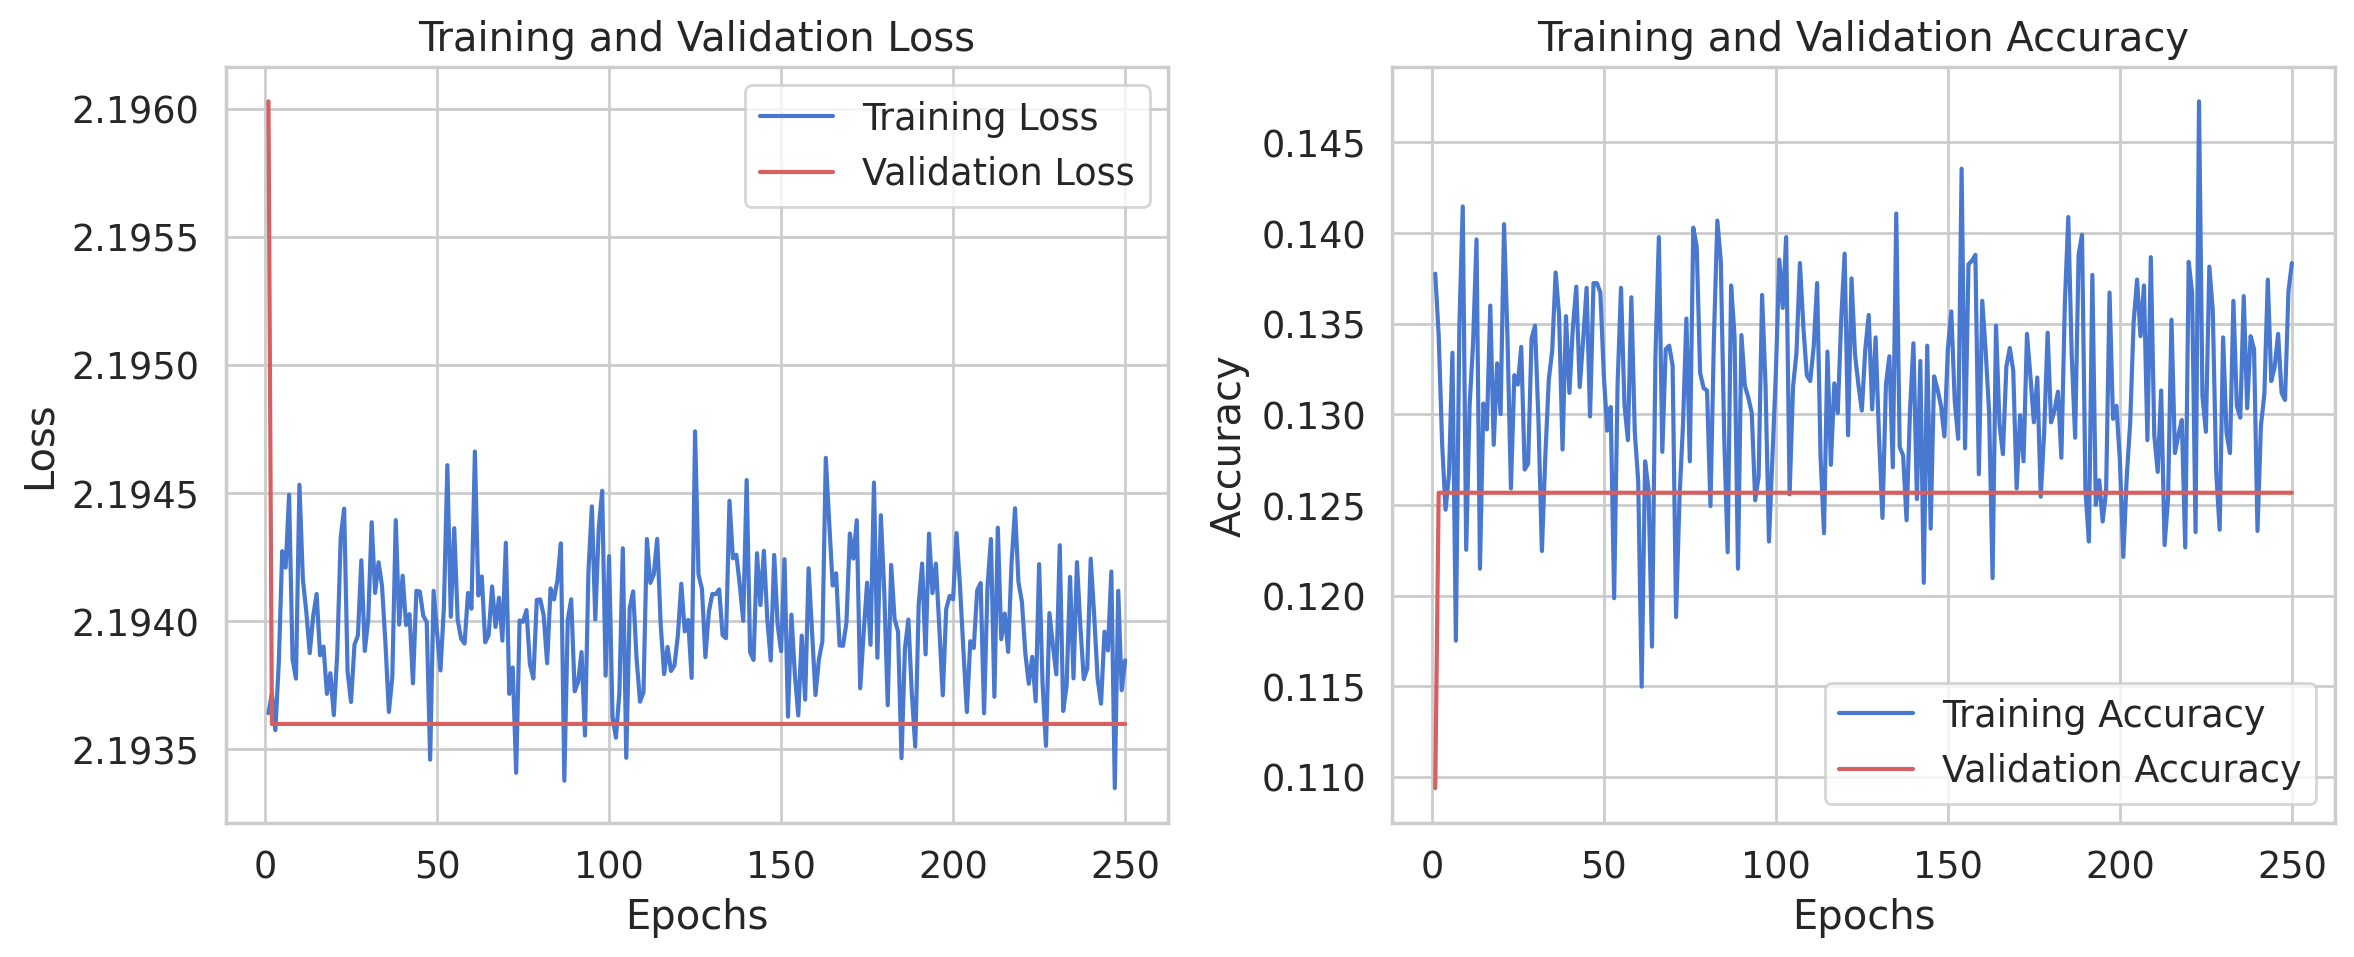

In [33]:
trainer.fit(model, data_module)
model.plot_metrics()